In [1]:
import sys
sys.path.append('../')
import os
os.chdir('../')
%reload_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"]="1" #,1,2,3

In [2]:
from models.rotation2xyz import Rotation2xyz
import numpy as np
from trimesh import Trimesh
import os
os.environ['PYOPENGL_PLATFORM'] = "osmesa"

import torch
from visualize.simplify_loc2rot import joints2smpl
import pyrender
import matplotlib.pyplot as plt

import io
import imageio
from shapely import geometry
import trimesh
from pyrender.constants import RenderFlags
import math
# import ffmpeg
from PIL import Image
from utils.motion_process import recover_from_ric
from os.path import join as pjoin

In [3]:
class WeakPerspectiveCamera(pyrender.Camera):
    def __init__(self,
                 scale,
                 translation,
                 znear=pyrender.camera.DEFAULT_Z_NEAR,
                 zfar=None,
                 name=None):
        super(WeakPerspectiveCamera, self).__init__(
            znear=znear,
            zfar=zfar,
            name=name,
        )
        self.scale = scale
        self.translation = translation

    def get_projection_matrix(self, width=None, height=None):
        P = np.eye(4)
        P[0, 0] = self.scale[0]
        P[1, 1] = self.scale[1]
        P[0, 3] = self.translation[0] * self.scale[0]
        P[1, 3] = -self.translation[1] * self.scale[1]
        P[2, 2] = -1
        return P

In [4]:
filedir = '/home/epinyoan/git/MaskText2Motion/T2M-BD/study/data/1a_temp.npy'
pose = np.load(filedir)
num_joints = 21 if pose.shape[-1] == 251 else 22
meta_dir = 'checkpoints/t2m/VQVAEV3_CB1024_CMT_H1024_NRES3/meta'
mean = np.load(pjoin(meta_dir, 'mean.npy'))
std = np.load(pjoin(meta_dir, 'std.npy'))
pose = pose * std + mean
pose_xyz = recover_from_ric(torch.from_numpy(pose).float(), num_joints)
pose_xyz = pose_xyz.numpy()
motions = pose_xyz

In [5]:
frames, njoints, nfeats = motions.shape
MINS = motions.min(axis=0).min(axis=0)
MAXS = motions.max(axis=0).max(axis=0)

height_offset = MINS[1]
motions[:, :, 1] -= height_offset
trajec = motions[:, 0, [0, 2]]

j2s = joints2smpl(num_frames=frames, device_id=0, cuda=True)
rot2xyz = Rotation2xyz(device=torch.device("cuda:0"))
faces = rot2xyz.smpl_model.faces

./body_models/


In [6]:
outdir = '/home/epinyoan/git/MaskText2Motion/T2M-BD/study/data/'
vertices_name = filedir.split('/')[-1].split('.')[0] + '_vertices.pt'


In [7]:
if (not os.path.exists(outdir + vertices_name)):
    print(f'Running SMPLify, it may take a few minutes.')
    motion_tensor, opt_dict = j2s.joint2smpl(motions)  # [nframes, njoints, 3]

    vertices = rot2xyz(torch.tensor(motion_tensor).clone(), mask=None,
                                    pose_rep='rot6d', translation=True, glob=True,
                                    jointstype='vertices',
                                    vertstrans=True)
    torch.save(vertices, outdir + vertices_name)
else:
    vertices = torch.load(outdir + vertices_name)

In [8]:
frames = vertices.shape[3] # shape: 1, nb_frames, 3, nb_joints
print (vertices.shape)
MINS = torch.min(torch.min(vertices[0], axis=0)[0], axis=1)[0]
MAXS = torch.max(torch.max(vertices[0], axis=0)[0], axis=1)[0]
# vertices[:,:,1,:] -= MINS[1] + 1e-5


out_list = []

minx = MINS[0] - 0.5
maxx = MAXS[0] + 0.5
minz = MINS[2] - 0.5 
maxz = MAXS[2] + 0.5
polygon = geometry.Polygon([[minx, minz], [minx, maxz], [maxx, maxz], [maxx, minz]])
polygon_mesh = trimesh.creation.extrude_polygon(polygon, 1e-5)



torch.Size([1, 6890, 3, 196])


In [9]:
meshes = []
polygon_renders = []
for i in range(frames):
    if i % 10 == 0:
        print(i)

        mesh = Trimesh(vertices=vertices[0, :, :, i].squeeze().tolist(), faces=faces)

        base_color = (.5, 0.53, 0.8, 0.5)
        ## OPAQUE rendering without alpha
        ## BLEND rendering consider alpha 
        material = pyrender.MetallicRoughnessMaterial(
            metallicFactor=0.2,
            alphaMode='OPAQUE',
            baseColorFactor=base_color
        )
        mesh = pyrender.Mesh.from_trimesh(mesh, material=material)

        
        meshes.append(mesh)
        # polygon_renders.append(polygon_render)
polygon_mesh.visual.face_colors = [.9, .9, .9, 0.9]
polygon_material = pyrender.MetallicRoughnessMaterial(
    metallicFactor=0.2,
    alphaMode='OPAQUE',
    smooth=True,
    baseColorFactor=(.9, .9, .9, 0.9)
)
polygon_render = pyrender.Mesh.from_trimesh(polygon_mesh, smooth=False)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


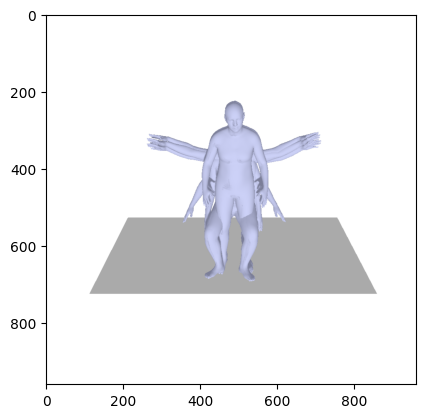

In [19]:
vid = []
bg_color = [1, 1, 1, 0.8]
scene = pyrender.Scene(bg_color=bg_color, ambient_light=(0.4, 0.4, 0.4))
sx, sy, tx, ty = [0.75, 0.75, 0, 0.10]
camera = pyrender.PerspectiveCamera(yfov=(np.pi / 4.0))
# camera = pyrender.OrthographicCamera(xmag=1.0, ymag=1.0)
light = pyrender.DirectionalLight(color=[1,1,1], intensity=300)
c = -np.pi / 2

for i, mesh in enumerate(meshes):
    scene.add(mesh)
scene.add(polygon_render, pose=np.array([[ 1, 0, 0, 0],
    [ 0, np.cos(c), -np.sin(c), MINS[1].cpu().numpy()],
    [ 0, np.sin(c), np.cos(c), 0],
    [ 0, 0, 0, 1]]))

light_pose = np.eye(4)
light_pose[:3, 3] = [0, -1, 1]
scene.add(light, pose=light_pose.copy())

light_pose[:3, 3] = [0, 1, 1]
scene.add(light, pose=light_pose.copy())

light_pose[:3, 3] = [1, 1, 2]
scene.add(light, pose=light_pose.copy())


c = -np.pi / 8

camera_y = 1.5
scene.add(camera, pose=[[ 1, 0, 0, (minx+maxx).cpu().numpy()],

                    [ 0, np.cos(c), -np.sin(c), camera_y],

                    [ 0, np.sin(c), np.cos(c), max(4, minz.cpu().numpy()+(camera_y-MINS[1].cpu().numpy())*2, (maxx-minx).cpu().numpy())],

                    [ 0, 0, 0, 1]
                    ])
# scene.add(camera, get_transformation_matrix(0, 0, 0, 3, 3, 3))
# scene.add(camera, lookAt(eye=np.array([-2., 1., 1.]), target=np.array([0. ,0., 0.]), up=np.array([0.0, 0.0, 1.0]), yz_flip=False))
# s = np.sqrt(2)/2
# camera_pose = np.array([
#     [0.0, -s,   s,   0.3],
#     [1.0,  0.0, 0.0, 0.0],
#     [0.0,  s,   s,   0.35],
#     [0.0,  0.0, 0.0, 1.0],
#  ])
# scene.add(camera, camera_pose)

# render scene
r = pyrender.OffscreenRenderer(960, 960)

color, _ = r.render(scene, flags=RenderFlags.SHADOWS_DIRECTIONAL ) # RenderFlags.RGBA
# Image.fromarray(color).save(outdir+name+'_'+str(i)+'.png')

vid.append(color)

r.delete()
imgplot = plt.imshow(vid[0])
plt.show()

In [56]:
mesh

In [45]:
# https://github.com/xuelin-chen/pcl2pcl-gan-pub/blob/468639c7022d9eeb76fdcfe5e94faaa03834c63c/pc2pc/tools/render_results/render_test_results.py#L15
def get_transformation_matrix(rx, ry, rz, tx, ty, tz):
    angles = np.array([rx, ry, rz])
    angles = angles / 180.0 * np.pi
    Rx = np.array([[1,0,0, 0],
                [0,np.cos(angles[0]),-np.sin(angles[0]),0],
                [0,np.sin(angles[0]),np.cos(angles[0]),0],
                [0,0,0,1]])
    Ry = np.array([[np.cos(angles[1]),0,np.sin(angles[1]),0],
                        [0,1,0,0],
                        [-np.sin(angles[1]),0,np.cos(angles[1]),0],
                        [0,0,0,1]])
    Rz = np.array([[np.cos(angles[2]),-np.sin(angles[2]),0,0],
                        [np.sin(angles[2]),np.cos(angles[2]),0,0],
                        [0,0,1,0],
                        [0,0,0,1]])
    T = np.array([
                [1.0, 0.0,  0.0, tx],
                [0.0, 1.0,  0.0, ty],
                [0.0, 0.0,  1.0, tz],
                [0.0, 0.0,  0.0, 1.0],
            ])
    pose = np.dot(Rz, np.dot(Ry,Rx))
    pose = np.dot(T, pose)
    return pose

In [49]:
# Camera LookAt
# https://github.com/mmatl/pyrender/issues/249
# https://github.com/Jianghanxiao/Helper3D/blob/master/trimesh_render/src/camera.py#L4
# https://github.com/Jianghanxiao/Helper3D/blob/dad57f14b7df6558888168f704440757701e6e55/demo_open3d_render.py#L40

def lookAt(eye, target, up, yz_flip=False):
    # Normalize the up vector
    up /= np.linalg.norm(up)
    forward = eye - target
    forward /= np.linalg.norm(forward)
    if np.dot(forward, up) == 1 or np.dot(forward, up) == -1:
        up = np.array([0.0, 1.0, 0.0])
    right = np.cross(up, forward)
    right /= np.linalg.norm(right)
    new_up = np.cross(forward, right)
    new_up /= np.linalg.norm(new_up)

    # Construct a rotation matrix from the right, new_up, and forward vectors
    rotation = np.eye(4)
    rotation[:3, :3] = np.row_stack((right, new_up, forward))

    # Apply a translation to the camera position
    translation = np.eye(4)
    translation[:3, 3] = [
        np.dot(new_up, eye),
        np.dot(right, eye),
        -np.dot(forward, eye),
    ]

    if yz_flip:
        # This is for different camera setting, like Open3D
        rotation[1, :] *= -1
        rotation[2, :] *= -1
        translation[1, 3] *= -1
        translation[2, 3] *= -1

    camera_pose = np.linalg.inv(np.matmul(translation, rotation))

    return camera_pose
# camera_pose = lookAt(eye=np.array([-2., 1., 1.]), target=np.array([0. ,0., 0.]), up=np.array([0.0, 0.0, 1.0]), yz_flip=True)